In [1]:
# import important libraries
import pandas as pd
import numpy as np

data_original = pd.read_csv("dataset/dataset_spams.csv", sep=",")

In [2]:
df = data_original.copy()

In [3]:
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [5]:
df['spam'].value_counts()

0    4360
1    1368
Name: spam, dtype: int64

## Looks like we have imbalanced dataset here!
Because there is a lot of non-spam here, let's try to undersample the non-spam side here to be equal with spam.

In [6]:
ham_indices = df[df.spam == 0].index
random_indices = np.random.choice(ham_indices, 1368, replace=False)
ham_sample = df.loc[random_indices]
ham_sample

,text,spam
2617,Subject: non - firm power curve building hi v...,0
5024,"Subject: re : hello gerry , let me review my...",0
3965,Subject: candidate vince : here is the resum...,0
2100,"Subject: enron , india database sandeep , ? ...",0
3209,Subject: re : revision of lst request i appro...,0
...,...,...
2038,Subject: understanding and applying financial ...,0
2426,"Subject: re : shane , thanks for your messag...",0
4720,"Subject: re : eott options tracy , attached ...",0
1516,Subject: zero curve generator for uk gilts an...,0


In [7]:
# combine reduced ham with spam
df2 = pd.concat([ham_sample, df[df['spam'] == 1]], verify_integrity=True)
df2['spam'].value_counts()

0    1368
1    1368
Name: spam, dtype: int64

In [8]:
# now that our data is balanced, let's split into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df2['text'], df2['spam'], 
                                                    test_size=0.1, 
                                                    stratify=df2['spam'],
                                                    random_state=1)
print('value counts of y_train is :', y_train.value_counts())

value counts of y_train is : 1    1231
0    1231
Name: spam, dtype: int64


## Feature Extraction

In [9]:
X_train[2]

'Subject: unbelievable new homes made easy  im wanting to show you this  homeowner  you have been pre - approved for a $ 454 , 169 home loan at a 3 . 72 fixed rate .  this offer is being extended to you unconditionally and your credit is in no way a factor .  to take advantage of this limited time opportunity  all we ask is that you visit our website and complete  the 1 minute post approval form  look foward to hearing from you ,  dorcas pittman'

In [20]:
X_train[5024]

'Subject: re : hello  gerry ,  let me review my calendar in the beginning of the next year and i shall  e - mail you  with a suggested date . my assistant will update my schedule for 2001 in the  first week  of january and i shall be able to select a date for ypur presentaton .  vince kaminski  " sheble , g . b . " on 12 / 21 / 2000 10 : 43 : 50 am  to : " \' vince . j . kaminski @ enron . com \' "  cc :  subject : re : hello  dear mr . kaminski  please excuse the cancellation due to illness . the students do not care who  they infect near the end of the semester , they just want to get done !  here is my available schedule for next year . i am now overloaded next week  with tasks to complete the semester . i do hope that we can reschedule  during the first quarter next year .  i would note that my schedule is most free for thursday or friday . i could  fly out late wednesday night .  cordially ,  gerry  teaching schedule  m 11 - 12  t and r 10 - 12 and 2 - 4  t 12 - 2 ep & es seminar 

In [10]:
# I would use tfvectorizer here
# text preprocessing part
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

stemmer = WordNetLemmatizer()
porter = PorterStemmer()
STOPWORDS = set(stopwords.words('english'))

def preprocessingText(corpus, lowercase=True, rmPunctuation=True, rpURL=True, rpNumber=True, stemming=True):
    """Input is assumed to be vector of documents"""

    documents = []
    for text in corpus:
        document = text

        # convert bytes into text
        if type(text) == bytes:    
            document = text.decode('utf-8', errors='ignore')

        # HYPERPARAMETER
        # Converting to Lowercase
        if lowercase:
            document = document.lower()

        # replace URL
        if rpURL:
            # replace URL
            document = re.sub(r'http\S+', 'url', document, flags=re.MULTILINE)

        # replace numbers
        if rpNumber:
            document = re.sub("\d+", "number", document)

        # remove all special characters including punctuation
        if rmPunctuation:
            # only keep word
            document = re.sub(r'\W', ' ', document)
            # remove all single characters
            document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
            # Remove single characters from the start
            document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # OTHER PREPROCESSING METHODS
        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)
        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)
        
        # removing stopwords
        document = document.split()
        document = [word for word in document if word not in STOPWORDS]

        if stemming:
            # Lemmatization
            document = [stemmer.lemmatize(word) for word in document]
            # stemming
            document = [porter.stem(word) for word in document]

        document = ' '.join(document)
        documents.append(document)
    return documents

[nltk_data] Downloading package stopwords to /home/jordan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/jordan/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# perform text processing before fitting
tfid = TfidfVectorizer()
tfid.fit(preprocessingText(X_train))

X_train_tf = tfid.transform(preprocessingText(X_train))
X_test_tf = tfid.transform(preprocessingText(X_test))
X_train_tf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Model Fitting
Decision tree, logistic regression, knn classifier. hyperparameters and predict generalization performance using cross validation. Use F1-score as a performance measure

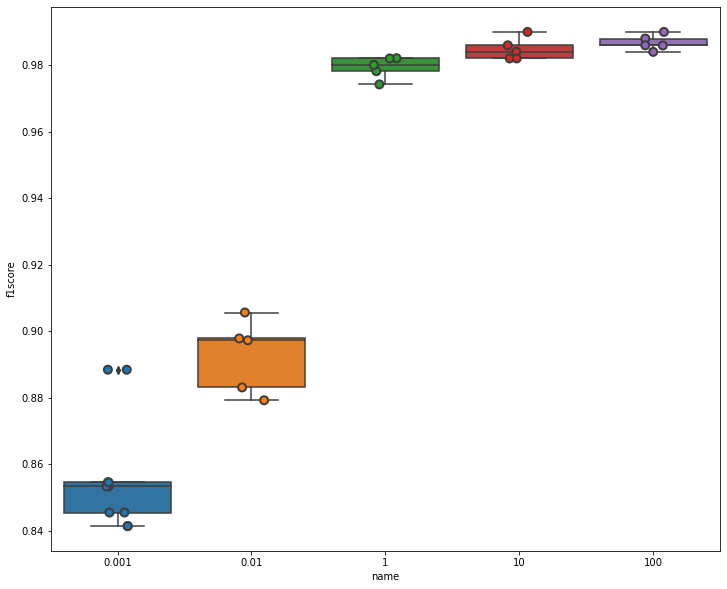

In [12]:
# let's do a quick comparison on different models
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# first logistic regression
Cs = [1e-3,0.001,0.01,1,10,100]
models = [LogisticRegression(C=c, solver='liblinear') for c in Cs]
scores = []

for C, model in zip(Cs, models):
    model_name = str(C)
    model_scores = cross_val_score(estimator=model, X=X_train_tf.toarray(), y=y_train, cv=5, scoring='f1')
    for fold_idx, score in enumerate(model_scores):
        scores.append((model_name, fold_idx, score))

cv_df = pd.DataFrame(scores, columns=['name', "fold_idx", "f1score"])

fig, ax = plt.subplots(figsize=(12,10))
sns.boxplot(x='name', y='f1score', data=cv_df)
sns.stripplot(x='name', y='f1score', data=cv_df, size=8, jitter=True, edgecolor='gray', linewidth=2)
plt.show()

C = 100 is the best here for logistic regression

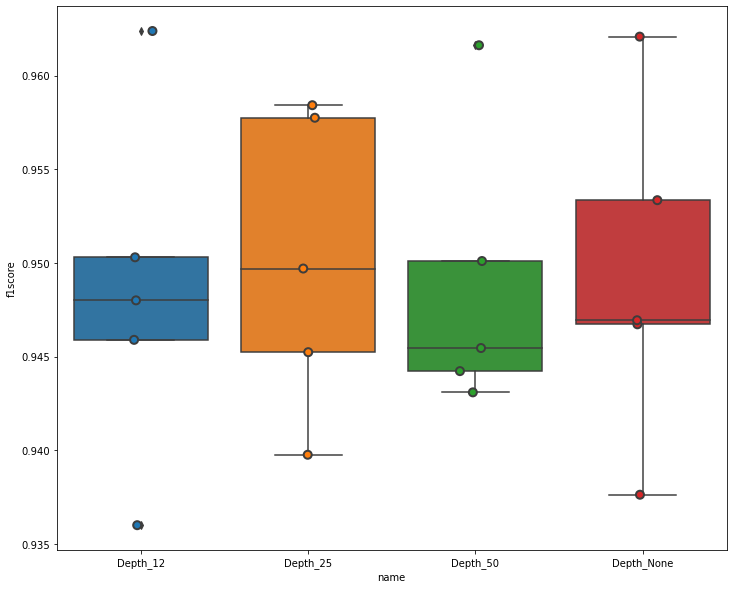

In [13]:
# second decision tree
max_depths = [12,25,50,None]
names = ['Depth_{}'.format(x) for x in max_depths]
models = [DecisionTreeClassifier(criterion='gini', max_depth=md) for md in max_depths]

scores = []

for name, model in zip(names, models):
    model_name = name
    model_scores = cross_val_score(estimator=model, X=X_train_tf.toarray(), y=y_train, cv=5, scoring='f1')
    for fold_idx, score in enumerate(model_scores):
        scores.append((model_name, fold_idx, score))

cv_df = pd.DataFrame(scores, columns=['name', "fold_idx", "f1score"])

fig, ax = plt.subplots(figsize=(12,10))
sns.boxplot(x='name', y='f1score', data=cv_df)
sns.stripplot(x='name', y='f1score', data=cv_df, size=8, jitter=True, edgecolor='gray', linewidth=2)
plt.show()

depth = 25 is the best for decision tree, f1 score is lower than logistic

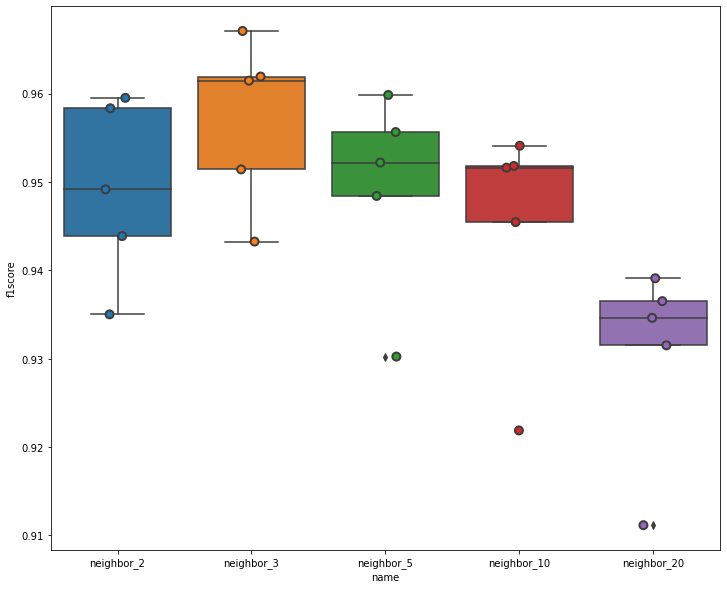

In [14]:
# third KNNs here
neighbors = [2, 3, 5, 10, 20]
knn_names = ['neighbor_{}'.format(n) for n in neighbors]
models = [KNeighborsClassifier(n_neighbors=n, p=2, metric='minkowski') for n in neighbors]

scores = []

for name, model in zip(knn_names, models):
    model_name = name
    model_scores = cross_val_score(estimator=model, X=X_train_tf.toarray(), y=y_train, cv=5, scoring='f1')
    for fold_idx, score in enumerate(model_scores):
        scores.append((model_name, fold_idx, score))

cv_df = pd.DataFrame(scores, columns=['name', "fold_idx", "f1score"])

fig, ax = plt.subplots(figsize=(12,10))
sns.boxplot(x='name', y='f1score', data=cv_df)
sns.stripplot(x='name', y='f1score', data=cv_df, size=8, jitter=True, edgecolor='gray', linewidth=2)
plt.show()

5 neighbor is the best among all knn models

## Create a forth classifier that is the ensemble of the three classifiers

In [15]:
# let's use soft voting here
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression(C=100, solver='liblinear')
clf2 = DecisionTreeClassifier(criterion='gini', max_depth=25)
clf3 = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')

eclf1 = VotingClassifier(estimators=[         
                        ('lr', clf1), ('dt', clf2), ('knn', clf3)], voting='soft')


In [16]:
eclf1.fit(X_train_tf.toarray(), y_train)
y_pred = eclf1.predict(X_test_tf.toarray())

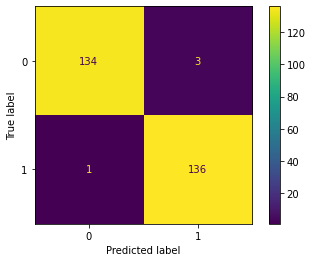

accuracy score on testing data is 98.54%
precision score on testing data is 97.84%
recall score on testing data is 99.27%
f1 score on testing data is 98.55%


In [17]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


plot_confusion_matrix(eclf1, X_test_tf.toarray(), y_test)
plt.show()

print("accuracy score on testing data is {:.2f}%".format(accuracy_score(y_test, y_pred) * 100 ))
print("precision score on testing data is {:.2f}%".format(precision_score(y_test, y_pred) * 100 ))
print("recall score on testing data is {:.2f}%".format(recall_score(y_test, y_pred) * 100 ))
print("f1 score on testing data is {:.2f}%".format(f1_score(y_test, y_pred) * 100 ))

Looks quite good! Three models ensembled together to give us a F1 score of 98.19%. Let's export our model...

In [22]:
import joblib

filename1 = '../deployment/models/tfid_convertor.sav'
joblib.dump(tfid, filename1)

filename2 = '../deployment/models/finalized_model.sav'
joblib.dump(eclf1, filename2)

['../deployment/models/finalized_model.sav']